In [165]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["JAX_ENABLE_X64"] = "True"

In [166]:
import jax
from jax import Array

from typing import Callable

import jax.scipy as jsp
import jax.numpy as jnp

from jax import random

import matplotlib.pyplot as plt

from bpd.prior import shear_transformation, ellip_mag_prior, sample_ellip_prior

from jax.numpy.linalg import norm

# get interim ellipticities
from functools import partial
from bpd.chains import run_inference_nuts
from jax import jit
from jax import vmap


In [167]:
def logtarget_ellip(
    e_sheared: Array,
    *,
    data: Array,  # renamed from `e_obs` for comptability with `do_inference_nuts`
    sigma_m: float,
    sigma_e_int: float,
):
    e_obs = data
    assert e_sheared.shape == (2,) and e_obs.shape == (2,)

    # ignore angle prior assumed uniform
    # prior enforces magnitude < 1.0 for posterior samples
    logprior = jnp.log(ellip_mag_prior(norm(e_sheared), sigma_e_int)) + jnp.log(1 / (2*norm(e_sheared)))
    loglike = jnp.sum(jsp.stats.norm.logpdf(e_obs, loc=e_sheared, scale=sigma_m))
    return logprior + loglike


In [ ]:
from jax import grad
from bpd.prior import inv_shear_func1, inv_shear_func2, inv_shear_transformation
_grad_fnc1 = vmap(vmap(grad(inv_shear_func1), in_axes=(0, None)), in_axes=(0, None))
_grad_fnc2 = vmap(vmap(grad(inv_shear_func2), in_axes=(0, None)), in_axes=(0, None))
_inv_shear_trans = vmap(inv_shear_transformation, in_axes=(0, None))


def shear_loglikelihood(
    g: Array,
    e_post: Array,
    *,
    sigma_e, 
    sigma_e_int,
):
    _, _, _ = e_post.shape  # (N, K, 2)

    #denom
    e_post_mag = norm(e_post, axis=-1)
    denom = jnp.log(ellip_mag_prior(e_post_mag, sigma=sigma_e_int)) + jnp.log(1/(2*e_post_mag))

    #num    \\\
    e_post_unsheared = _inv_shear_trans(e_post, g)
    e_post_unsheared_mag = norm(e_post_unsheared, axis=-1)

    grad1 = _grad_fnc1(e_post, g)
    grad2 = _grad_fnc2(e_post, g)
    absjacdet = jnp.abs(grad1[..., 0] * grad2[..., 1] - grad1[..., 1] * grad2[..., 0])

    num1 = jnp.log(ellip_mag_prior(e_post_unsheared_mag, sigma=sigma_e))
    num2 = jnp.log(1 / (2*e_post_unsheared_mag))
    num3 = jnp.log(absjacdet)
    num = num1 + num2 + num3 # (N, K)

    ratio = jsp.special.logsumexp(num - denom, axis=-1)
    return ratio.sum()

def logtarget_shear(g:Array, *, data: Array, loglikelihood: Callable):
    loglike = loglikelihood(g, e_post=data)
    logprior = jsp.stats.norm.logpdf(g, loc=0, scale=0.01).sum()
    # logprior = jsp.stats.uniform.logpdf(g, -0.1, 0.2).sum()
    return logprior + loglike




In [247]:
rng_key = random.key(33)
keys = random.split(rng_key, 10)

In [248]:
sigma_e = 1e-2
sigma_e_int = 3e-2
sigma_m=1e-4

g1 = 0.02
g2 = 0.0
true_g = jnp.array([g1, g2])
n_gals = 1_000

In [249]:
e = sample_ellip_prior(keys[0], sigma=sigma_e, n=n_gals)

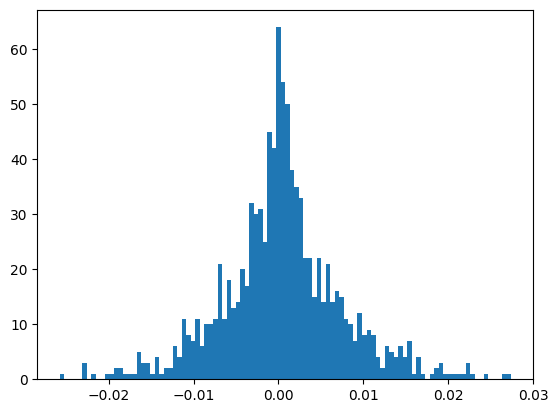

In [250]:
_ = plt.hist(e[:, 0], bins=100)

In [251]:
jnp.std(e[:, 0]), jnp.std(e[:, 1]), sigma_e/jnp.sqrt(2)

(Array(0.00712878, dtype=float64),
 Array(0.00715151, dtype=float64),
 Array(0.00707107, dtype=float64, weak_type=True))

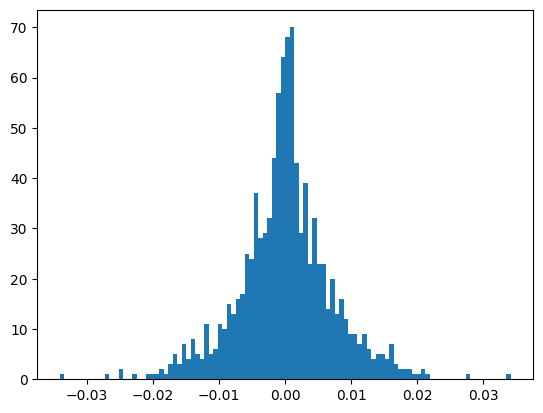

In [252]:
_ = plt.hist(e[:, 1], bins=100)

In [253]:
e_sheared = shear_transformation(e, true_g)
e_obs = random.normal(keys[1], shape=(n_gals, 2)) * sigma_m + e_sheared
e_sheared.shape, e_obs.shape

((1000, 2), (1000, 2))

In [254]:
std_e1 = e_sheared[:, 0].std()
std_e1, e[:,0].std()

(Array(0.00712584, dtype=float64), Array(0.00712878, dtype=float64))

In [255]:

_logtarget = partial(logtarget_ellip, sigma_m=sigma_m, sigma_e_int=sigma_e_int)
keys3 = random.split(keys[2], n_gals)
_do_inference_jitted = jit(
    partial(
        run_inference_nuts,
        logtarget=_logtarget,
        n_samples=100,
        initial_step_size=max(sigma_e, sigma_m),
        max_num_doublings=2,
        n_warmup_steps=500,
    )
)
_do_inference = vmap(_do_inference_jitted, in_axes=(0, 0, 0))

# compile
_ = _do_inference(keys3[:2], e_sheared[:2], e_obs[:2])

e_post = _do_inference(keys3, e_sheared, e_obs)


In [256]:
e_post.shape

(1000, 100, 2)

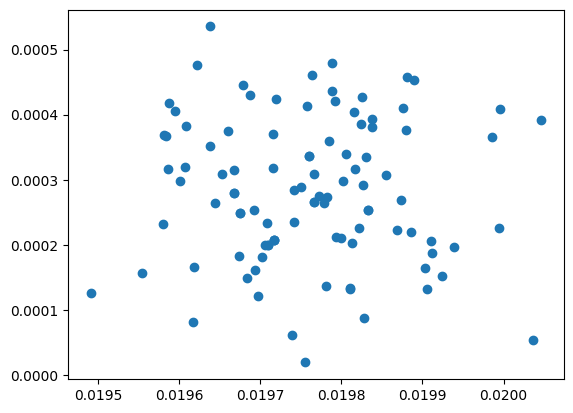

In [257]:
plt.scatter(e_post[1, :, 0], e_post[1, :, 1])

In [258]:
_loglikelihood = jit(
    partial(
        shear_loglikelihood,
        sigma_e=sigma_e,
        sigma_e_int=sigma_e_int,
    )
)
_logtarget = partial(logtarget_shear, loglikelihood=_loglikelihood)

_do_inference = partial(
    run_inference_nuts,
    data=e_post,
    logtarget=_logtarget,
    n_samples=5000,
    n_warmup_steps=1000,
    max_num_doublings=10,
    initial_step_size=0.01,
)

In [259]:
g_samples = _do_inference(keys[5], true_g)

In [260]:
g_samples.shape

(5000, 2)

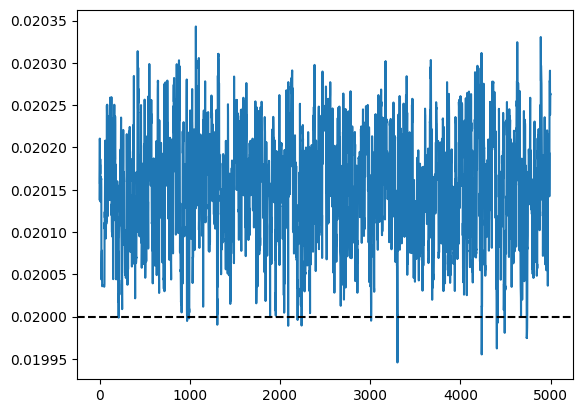

In [261]:
plt.plot(g_samples[:, 0])
plt.axhline(0.02, color='k', linestyle='--')

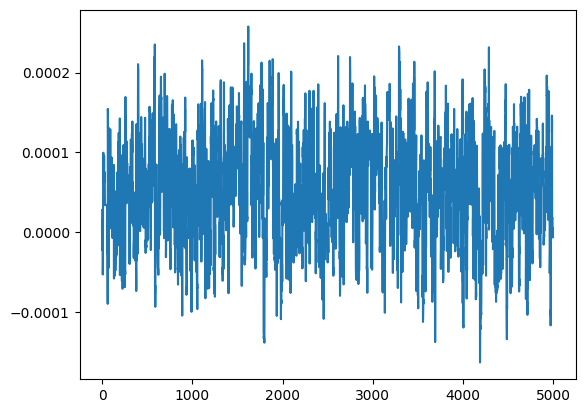

In [262]:
plt.plot(g_samples[:, 1])

Parameter g1 in chain post0 is not constrained


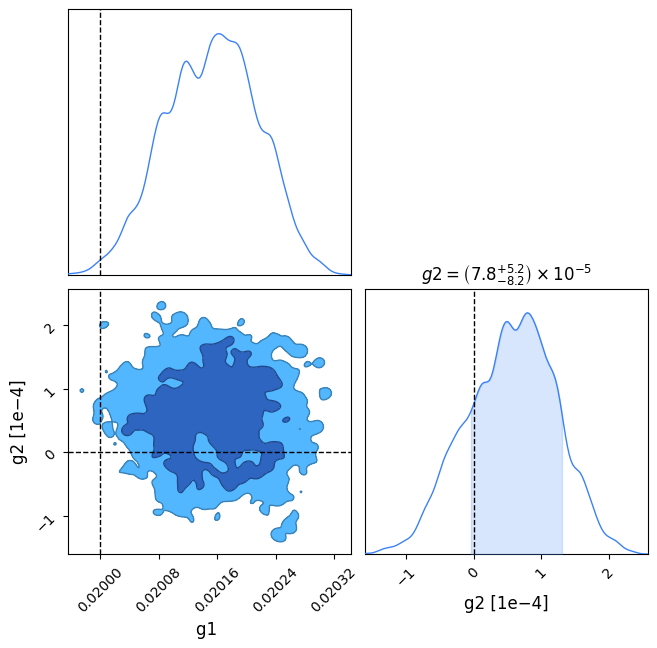

In [263]:
from bpd.diagnostics import get_contour_plot

_ = get_contour_plot([{'g1':g_samples[:, 0], 'g2':g_samples[:, 1]}], ['post0'], {'g1':0.02, 'g2':0.0})

In [264]:
g_samples[:, 0].mean()

Array(0.02015282, dtype=float64)

In [271]:
g_samples[:, 0].std(), std_e1/ jnp.sqrt(n_gals)

(Array(6.31871383e-05, dtype=float64), Array(0.00022534, dtype=float64))

In [272]:
g_samples[:, 1].std()

Array(6.5924217e-05, dtype=float64)

In [273]:
std_e1 / jnp.sqrt(1000)

Array(0.00022534, dtype=float64)

In [277]:
g_samples[:, 0].mean() - 3*g_samples[:, 0].std()

Array(0.01996326, dtype=float64)

In [275]:
g_samples[:, 1].mean() + 2*g_samples[:, 1].std()

Array(0.00018769, dtype=float64)

In [276]:
sigma_e / jnp.sqrt(1000)

Array(0.00031623, dtype=float64, weak_type=True)